In [2]:
import matplotlib.pyplot as plt
import numpy as np # should be 1.19
import os
import PIL # load images
import tensorflow as tf # tf 2.5.0

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib # similar to os
import keras_tuner as kt # for tuning hyperparameters

# import seaborn as sns
# sns.set()

### Load dataset

In [3]:
# Import path Food101 dataset
# https://www.kaggle.com/kmader/food41?select=images 
data_dir = pathlib.Path(str(pathlib.Path.cwd()) + '/food101/sub_images')
data_dir

PosixPath('/Users/alicis/Documents/WorkProjects/Image_classification/food101/sub_images')

In [4]:
# Show image count
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

10000


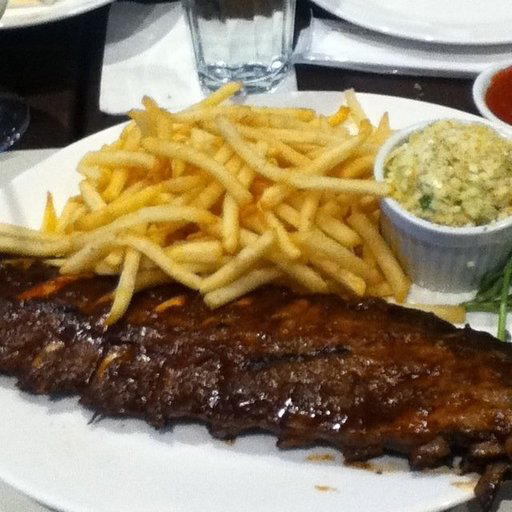

In [5]:
# Show example img
roses = list(data_dir.glob('baby_back_ribs/*'))
PIL.Image.open(str(roses[3])) # Open path roses[0]

### Split dataset

In [6]:
# Intialize parameter
batch_size = 10 # update every n 
img_size = (180,180) # resize images

In [47]:
# training dataset 80%
train_dataset = tf.keras.preprocessing.image_dataset_from_directory( # Shuffle everytime the variable is called
    data_dir,
    validation_split=0.2,
    subset="training", # type of spliting
    seed=123, # same spilt
    image_size= img_size, # Reshape images
    batch_size=batch_size # update size
)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.


In [48]:
# validation dataset 20%
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size= img_size,
  batch_size=batch_size)

Found 10000 files belonging to 10 classes.
Using 2000 files for validation.


### Show splited dataset 

In [39]:
with open('food101/meta/sub_classes.txt','r') as f:
    class_names = f.read().splitlines() #f.readlines() for included \n
len(class_names)    

10

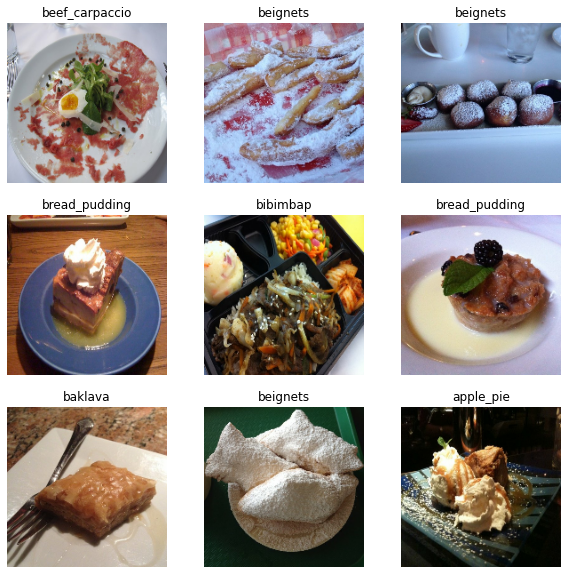

In [40]:
# visualize multiple images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
# Check image shape/size
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(10, 180, 180, 3)
(10,)


In [49]:
# Create test dataset from validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 160
Number of test batches: 40


### Configure the dataset for performance

In [12]:
# To yield data from disk without I/O become blocking, buffered prefetching are implemented
# train and val buffer size (https://stackoverflow.com/questions/47781375/tensorflow-dataset-shuffle-large-dataset)
AUTOTUNE = tf.data.AUTOTUNE # autotune buffersize

# cache(): keeps the images in memory after they're loaded off disk during the first epoch
# prefetch(): overlaps data preprocessing and model execution while training.
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [18]:
# Add more sample
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

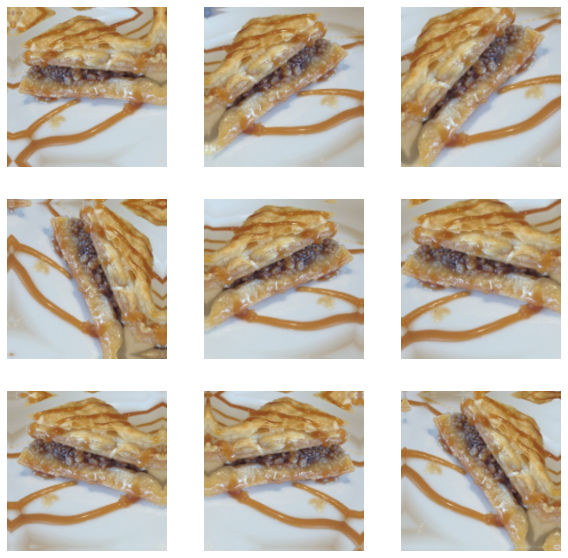

In [19]:
# Plot augmentation data
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Extract image and lable from batch tensors
# y = np.concatenate([y for x, y in train_ds], axis=0) for additional method
for images, labels in train_dataset:  # only take first element of dataset
    images = images.numpy()
    label = labels.numpy()
print (images.shape)
print (label.shape)

### Create the model (Transfer learner)

In [20]:
# Preprocessing layer (Rescaling layer)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# Rescaling layer (alternative)
# rescale = tf.leras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

In [21]:
# Create the base model from the pre-trained model MobileNet V2
img_shape = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.summary()

9412608/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
________________

In [22]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features to use MobileNetV2
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 6, 6, 1280)


In [23]:
# Feature extraction (Freeze the convolution base)
base_model.trainable = False

In [24]:
# Global Average Pooling 2D layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [31]:
# Prediction layers with Relu activiton
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 10)


In [32]:
# Modify and create model by Kerasa functional api
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [60]:
# Complie model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [61]:
len(model.trainable_variables)

2

In [62]:
validation_dataset.take(1)

<TakeDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [63]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

160/160 [==============================] - 23s 139ms/step - loss: 2.9223 - accuracy: 0.0981


In [64]:
# Train transfer learner model
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
800/800 [==============================] - 143s 176ms/step - loss: 1.9445 - accuracy: 0.3322 - val_loss: 1.2902 - val_accuracy: 0.5694
Epoch 2/10
800/800 [==============================] - 140s 174ms/step - loss: 1.2446 - accuracy: 0.5649 - val_loss: 1.0248 - val_accuracy: 0.6556
Epoch 3/10
800/800 [==============================] - 139s 174ms/step - loss: 1.0599 - accuracy: 0.6357 - val_loss: 0.9136 - val_accuracy: 0.6956
Epoch 4/10
800/800 [==============================] - 138s 173ms/step - loss: 0.9625 - accuracy: 0.6774 - val_loss: 0.8534 - val_accuracy: 0.7100
Epoch 5/10
800/800 [==============================] - 138s 172ms/step - loss: 0.8952 - accuracy: 0.6920 - val_loss: 0.8222 - val_accuracy: 0.7231
Epoch 6/10
800/800 [==============================] - 139s 174ms/step - loss: 0.8598 - accuracy: 0.7031 - val_loss: 0.7948 - val_accuracy: 0.7331
Epoch 7/10
800/800 [==============================] - 140s 175ms/step - loss: 0.8351 - accuracy: 0.7119 - val_loss: 0.7689 -

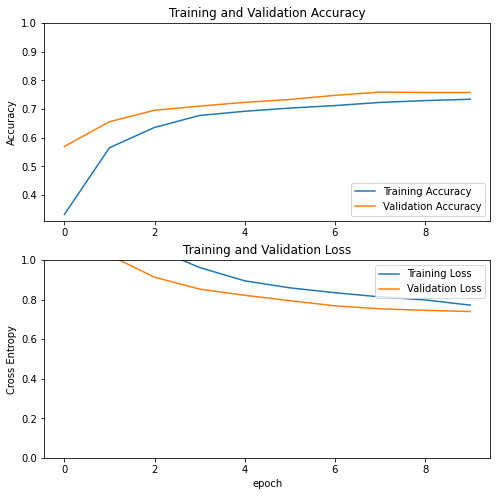

In [65]:
# Visualize accuracy between training and validation dataset
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-tuning model

In [66]:
base_model.trainable = True

# Print number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [70]:
# Compile model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [72]:
# Trainable variables
len(model.trainable_variables)

56

In [73]:
# Continue Learning from previous learning epochs
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
800/800 [==============================] - 202s 248ms/step - loss: 0.7525 - accuracy: 0.7380 - val_loss: 0.6597 - val_accuracy: 0.7744
Epoch 11/20
800/800 [==============================] - 195s 244ms/step - loss: 0.6490 - accuracy: 0.7736 - val_loss: 0.6593 - val_accuracy: 0.7881
Epoch 12/20
800/800 [==============================] - 196s 245ms/step - loss: 0.5840 - accuracy: 0.7979 - val_loss: 0.5963 - val_accuracy: 0.8081
Epoch 13/20
800/800 [==============================] - 199s 248ms/step - loss: 0.5371 - accuracy: 0.8135 - val_loss: 0.5903 - val_accuracy: 0.8075
Epoch 14/20
800/800 [==============================] - 210s 262ms/step - loss: 0.4887 - accuracy: 0.8325 - val_loss: 0.5577 - val_accuracy: 0.8138
Epoch 15/20
800/800 [==============================] - 214s 268ms/step - loss: 0.4563 - accuracy: 0.8425 - val_loss: 0.5867 - val_accuracy: 0.8150
Epoch 16/20
800/800 [==============================] - 217s 271ms/step - loss: 0.4200 - accuracy: 0.8539 - val_loss: 0

In [74]:
# Accumulate accuracy and loss
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

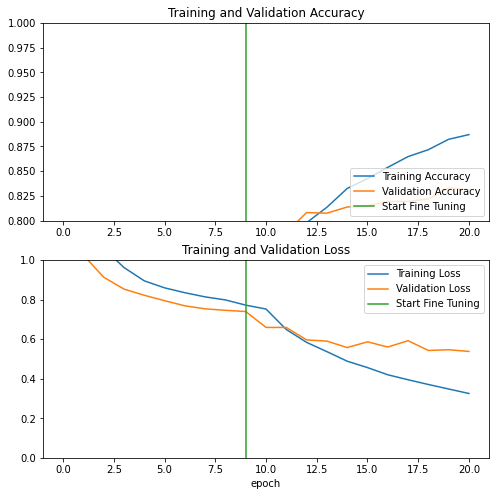

In [75]:
# Visualize Fine-tuning model
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [78]:
# Save model
model.save('food101_mode03072021')

/Users/alicis/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: food101_mode03072021/assets


In [79]:
# Evaluate/predict model by testing dataset
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

40/40 [==============================] - 6s 141ms/step - loss: 0.5144 - accuracy: 0.8300
Test accuracy : 0.8299999833106995


Predictions:
 [6 5 2 9 6 8 7 1 7]
Labels:
 [6 5 2 7 6 8 7 1 7 8]

 ['beignets', 'beet_salad', 'baklava', 'bibimbap', 'beignets', 'bread_pudding', 'bibimbap', 'baby_back_ribs', 'bibimbap', 'bread_pudding']


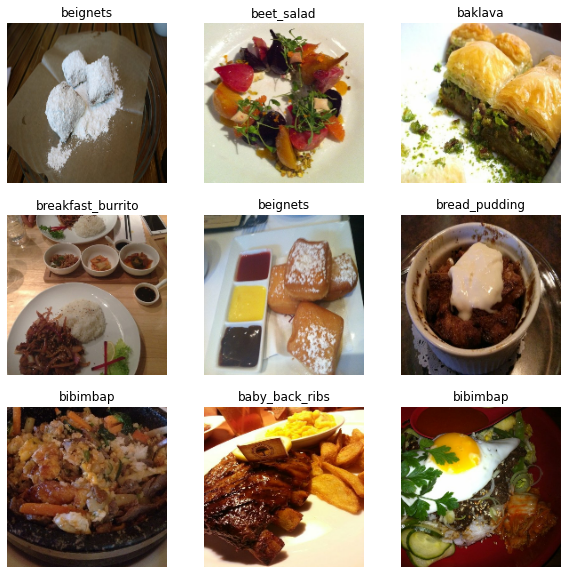

In [129]:
# Visualize evaluating model
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a softmax since our model returns mulitple classes
predictions = tf.nn.softmax(predictions)
label_class = [class_names[item] for item in label_batch]
predictions = [np.argmax(predictions[i]) for i in range(9)]

print('Predictions:\n', np.asarray(predictions))

print('Labels:\n', label_batch)
print('\n', label_class)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")